[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/<your-username>/<your-repo>/blob/main/<your-notebook>.ipynb)

In [6]:
from IPython.display import display, Latex
from scipy.special import comb
import numpy as np

## Efficient Computation of Order--K Index-Powered Weighted Sums Using Cascaded Accumulators

This notebook is **complementary material** to the paper:  **"Efficient Computation of Order--K Index-Powered Weighted Sums Using Cascaded Accumulators"**  
Authors: Deijany Rodriguez Linares, Oksana Moryakova and Håkan Johansson \
Year: 2025  

It demonstrates how to reproduce the paper, and provides reusable code for computing index-powered weighted sums of the form $S_K(N) = \sum_{n=0}^{N-1} n^K * v[n]$, via cascaded accumulators.

**Copyright and License**  
© 2025 Your Name(s). This notebook is distributed for research and educational use.  
License: CC-BY-4.0

**How to cite**  
If you use this notebook, please cite the paper:  
> D. R. Linares, O. Moryakova, and H. Johansson, "Efficient Computation of Order--K Index-Powered Weighted Sums Using Cascaded Accumulators", 2025.

---

### Objective
Given a sequence $v[n]$ and integers $K, N \geq 0$, we want to compute $S_K(N) = \sum_{n=0}^{N-1} n^K * v[n]$.

The idea is that instead of multiplying by $n^K$ directly, we can rewrite the weighted sum as a linear combination of cascaded accumulators applied to $v[n]$. This turns the power-weighted sum into just a few prefix sums.  

What are accumulators?  
Accumulators are essentially first-order IIR filters that compute the recurrence 

\begin{equation}
A_k[N-1]\hspace{-3 pt} = \hspace{-3 pt}A_k[n\hspace{-1.0 pt}-\hspace{-1.0 pt}1] \hspace{-1 pt}+ \hspace{-1 pt}A_{k-1}[n],   \begin{cases} \quad
    \hspace{-2 pt}A_0[n] = v[n], \quad \text{(the input)} \\
    A_k[-1] = 0, \,\, \forall k \in \hspace{-1 pt} \mathbb{Z}[1, K].
  \end{cases}
\end{equation}

In short, each accumulator has a memory of one sample, and requires $N-1$ additions to compute its output.  

### What are cascaded accumulators?  
A cascaded-accumulators structure is then obtained by chaining several of these units in series (see figure below).  

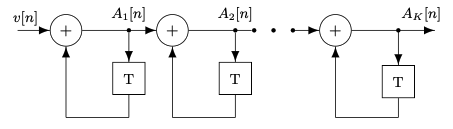

#### The following block implements code to compute $c_k$ as a function of $N$ for a given $K$

In [7]:
# =========================================================
# Utility functions
# ---------------------------------------------------------
# - binomial_coefficient(n,k): custom implementation of C(n,k)
# - estimate_ck_simp(N,K,k): direct formula for a single c_k(N)
# - ck_polys(K): expand all c_k(N) (k=1..K+1) as polynomials in N
# - poly_str(coeff): pretty-print a polynomial from coefficient list
# - print_ck(K): convenience function to display all c_k(N) polynomials
#
# Example: for K=2 we obtain
#   c_1(N) = N^2
#   c_2(N) = -2N - 1
#   c_3(N) = 2
# =========================================================
def binomial_coefficient(n, k):
    if k > n:               # it is proved from the general binomial theorem
        return 0
    if k == 0 or k == n:    # from equation n!/[k!(n-k)!]
        return 1
    num = 1
    denom = 1
    for i in range(1, k+1):
        num *= (n - i + 1)
        denom *= i
    return num // denom

def estimate_ck_simp(N, K, k):
    """c_k(N) = sum_{j=0}^{k-1} (-1)^j * C(k-1,j) * (N+j)^K"""
    term = 0
    for j in range(k):
        term += ((-1)**j) * binomial_coefficient(k-1, j) * (N + j)**K
    return term
   
def ck_polys(K):
    """Return all c_k(N) polynomials (k=1..K+1) as coeff lists for N^0..N^K"""
    out = []
    for k in range(1, K+2):  
        coeff = [0]*(K+1)  # N^0..N^K
        for j in range(k):
            s = ((-1)**j) * binomial_coefficient(k-1, j)
            # (N+j)^K = sum_{t=0}^K C(K,t) * N^{K-t} * j^t
            for t in range(K+1):
                coeff[K-t] += s * binomial_coefficient(K, t) * (j**t)
        out.append(coeff)
    return out

def poly_str(coeff):
    """Print polynomial given coeffs for N^0..N^deg"""
    terms = []
    for p in range(len(coeff)-1, -1, -1):
        c = coeff[p]
        if c == 0: 
            continue
        s = (' - ' if c < 0 else (' + ' if terms else ''))
        a = abs(c)
        if p == 0: t = f'{a}'
        elif p == 1: t = ('N' if a == 1 else f'{a}N')
        else: t = (f'N^{p}' if a == 1 else f'{a}N^{p}')
        terms.append(s + t)
    return ''.join(terms) if terms else '0'

def print_ck(K):
    """Print all c_k(N) for given K using your binomial_coefficient()"""
    for k, coeff in enumerate(ck_polys(K), 1):
        print(f'c_{k}(N) = {poly_str(coeff)}')

# Example:
# print_ck(K=2)  # -> c_1(N)=N^2, c_2(N)=-2N-1, c_3(N)=2
print_ck(K=4)

c_1(N) = N^4
c_2(N) =  - 4N^3 - 6N^2 - 4N - 1
c_3(N) = 12N^2 + 24N + 14
c_4(N) =  - 24N - 36
c_5(N) = 24


### Next we presents numerical results validating our method for selected $(N, K)$ pairs.

In [8]:
# =========================================================
# This block computes:
# 1. The output of cascaded accumulators
#    1.1 Using a straightforward approach
#    1.2 Using the binomial-coefficient based derivation
# 2. The target sum S_K = sum_{n=0}^{N-1} n^K * v[n]
#    computed by three methods:
#    2.1 Direct definition
#    2.2 Via cascaded accumulators (straightforward)
#    2.3 Via cascaded accumulators (binomial-based)

# =========================================================
#  Cascaded accumulator outputs (straightforward) 
# -------------------------------------
def accumulator(x_input):
    # Initialize sum_ as an array of zeros with the same shape as x_input
    sum_ = np.zeros_like(x_input, dtype=np.float64)
    # Initialize a running total
    total = 0
    # Accumulate values in x_input
    for idx, value in enumerate(x_input):
        total += value
        sum_[idx] = total
    return sum_

def cascaded_accumulators_straightforward(v_input, K):
    """Compute A_1,...,A_K using cascaded running sums"""
    A_vector = np.zeros(K, dtype=np.float64)
    x = v_input.copy()
    for k in range(1, K+1):
        x = accumulator(x)          # feed through another accumulator
        A_vector[k-1] = x[-1]       # store A_k[N-1]
    return A_vector

# =========================================================
# Cascaded accumulator outputs (based binomial coefficients) 
# -------------------------------------
def cascaded_accumulator_binomial(v_input, K):
    N = len(v_input)
    A_vector = np.zeros(K, dtype=np.float64)
    for k in range(1, K + 1):
        s = 0.0
        for n in range(N):
            s += binomial_coefficient(N - n + k - 2, k - 1) * v_input[n]
        A_vector[k - 1] = s
    return A_vector

# =========================================================
# Sum by Direct definition
# -------------------------------------
def sum_direct_evaluation(v_input, K):
    """Compute S_K(N) = sum_{n=0}^{N-1} n^K * v[n]"""
    N = len(v_input)
    n = np.arange(N)
    return np.sum((n**K) * v_input)

# =========================================================
# Sum based on accumulators 
# -------------------------------------
def ck_vector(N, K):
    # [c_1(N), ..., c_{K+1}(N)]
    return np.array([estimate_ck_simp(N, K, k) for k in range(1, K+2)], dtype=np.float64)

def Sum_from_accumulators(A_vector, N, K):
    # requires A_vector = [A_1[N-1], ..., A_{K+1}[N-1]]
    return float(np.dot(ck_vector(N, K), A_vector))


# ==========================
# Example
K = 5    # order n^K
N = 10    # Number of samples of the input v[n]
v= np.random.rand(N)/25 # input

# Printing the input
print(f'Computing sum S_K = sum_(n=0)^(N-1) n^K * v[n] for order K={K}, and N={N} samples ')
print('-'*70, '\n')

print('v_input',v)

# Computing cascaded accumulators output
A_vector_straightforward = cascaded_accumulators_straightforward(v, K+1)
A_vector_binomial = cascaded_accumulator_binomial(v, K+1)

formatted_output = ', '.join([f'A_{i+1}(N) = {num:.8f}' for i, num in enumerate(A_vector_straightforward)])
print('-'*50)
print('Accumulators output (Straightforward output):\n', formatted_output)
print('-'*15)
formatted_output = ', '.join([f'A_{i+1}(N) = {num:.8f}' for i, num in enumerate(A_vector_binomial)])
print('Accumulators output (Binomial based output):\n', formatted_output)
print('-'*50)

# Computing Order--K Index-Powered Weighted Sums
S_K_direct = sum_direct_evaluation(v, K)
S_K_via_A_straightforward = Sum_from_accumulators(A_vector_straightforward, N=len(v), K=K)
S_K_via_A_binomial = Sum_from_accumulators(A_vector_binomial, N=len(v), K=K)

print('Sums:')
print(f"S_{K}({N}) = {S_K_direct:.8f}   (via straightforward implementation)")
print(f"S_{K}({N}) = {S_K_via_A_straightforward:.8f}   (via proposed with straightforward accumulators)")
print(f"S_{K}({N}) = {S_K_via_A_binomial:.8f}   (via proposed with binomial-based accumulators)")

Computing sum S_K = sum_(n=0)^(N-1) n^K * v[n] for order K=5, and N=10 samples 
---------------------------------------------------------------------- 

v_input [0.0173573  0.02618207 0.00218485 0.01503946 0.02134622 0.01959345
 0.01801984 0.03498632 0.00145901 0.02862844]
--------------------------------------------------
Accumulators output (Straightforward output):
 A_1(N) = 0.18479697, A_2(N) = 0.96659608, A_3(N) = 3.79789867, A_4(N) = 12.29002911, A_5(N) = 34.50246321, A_6(N) = 86.75350924
---------------
Accumulators output (Binomial based output):
 A_1(N) = 0.18479697, A_2(N) = 0.96659608, A_3(N) = 3.79789867, A_4(N) = 12.29002911, A_5(N) = 34.50246321, A_6(N) = 86.75350924
--------------------------------------------------
Sums:
S_5(10) = 2553.26549761   (via straightforward implementation)
S_5(10) = 2553.26549761   (via proposed with straightforward accumulators)
S_5(10) = 2553.26549761   (via proposed with binomial-based accumulators)


In [9]:
# Reminder: you can display the closed-form expressions of c_k(N)
# for a given order K by calling:
print_ck(K)

c_1(N) = N^5
c_2(N) =  - 5N^4 - 10N^3 - 10N^2 - 5N - 1
c_3(N) = 20N^3 + 60N^2 + 70N + 30
c_4(N) =  - 60N^2 - 180N - 150
c_5(N) = 120N + 240
c_6(N) =  - 120


#### The following block presents the complexity of our method compared with the direct implementation and an optimal addition-chain exponentiation for the selected pair $(N, K)$.

In [10]:
from collections import deque

def optimal_addition_chain(K):
    """Return an optimal (shortest) addition chain for exponent K (BFS; good for K<=256)."""
    if K < 1: return [0]
    chains = deque([[1]])
    seen = {tuple([1])}
    while chains:
        c = chains.popleft()
        if c[-1] == K: return c
        last = c[-1]
        # extend by sums of any two elements (a_i + a_j)
        gen = set()
        for i in range(len(c)-1, -1, -1):
            for j in range(i, -1, -1):
                s = c[i] + c[j]
                if s > last and s <= K:
                    gen.add(s)
        for s in sorted(gen):
            nc = c + [s]
            t = tuple(nc)
            if t not in seen:
                seen.add(t)
                chains.append(nc)

def complexity_summary(N, K):
    """Return (proposed, direct, add_chain_total, chain) multiplications."""
    chain = optimal_addition_chain(K)      # e.g., [1,2,3,6,12,...,K]
    lK = len(chain) - 1                    # mults to compute n^K
    proposed = K + 1                       # c_k * A_k[N-1]
    direct = K * N                         # n^K via direct per n
    add_chain_total = N * (lK + 1)         # per n: lK for n^K + 1 for *v[n]
    return proposed, direct, add_chain_total, chain

def print_summary(proposed, direct, achain, chain):
    """
    Pretty-print the complexity results with colors:
    - Best (minimum) cost shown in green
    - Worst (maximum) cost shown in red
    - Others shown in orange """
    GREEN, ORANGE, RED, RESET = "\033[92m", "\033[93m", "\033[91m", "\033[0m"


    values = {
        "Proposed": proposed,
        "Direct": direct,
        "Addition-chain": achain
    }
    best, worst = min(values.values()), max(values.values())

    print(f"Number of multiplications for each method (K={K}, N={N}):")
    for name, val in values.items():
        color = GREEN if val == best else RED if val == worst else ORANGE
        if name == "Addition-chain":
            print(f"{color}{name}: {val}, Chain: {chain}{RESET}")
        else:
            print(f"{color}{name}: {val}{RESET}")


# Example:
N, K = 100, 17
proposed, direct, achain, chain = complexity_summary(N, K)
print_summary(proposed, direct, achain, chain)
# print(f" Proposed: {proposed}, Direct: {direct}, Addition-chain: {achain}, Chain: {chain}")

Number of multiplications for each method (K=17, N=100):
Proposed: 18
Direct: 1700
Addition-chain: 600, Chain: [1, 2, 4, 8, 9, 17]
